In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# 데이터 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # DCGAN은 [-1, 1] 범위로 데이터를 정규화
])

# CIFAR-10 데이터셋 로드
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# 고양이(클래스 레이블 3) 이미지만 선택
cat_indices = [i for i, (_, label) in enumerate(cifar10_dataset) if label == 3] # 인덱스 추출
cat_dataset = Subset(cifar10_dataset, cat_indices) # 인덱스에 대응하는 데이터 추출

# DataLoader 생성
batch_size = 128
dataloader = DataLoader(cat_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified


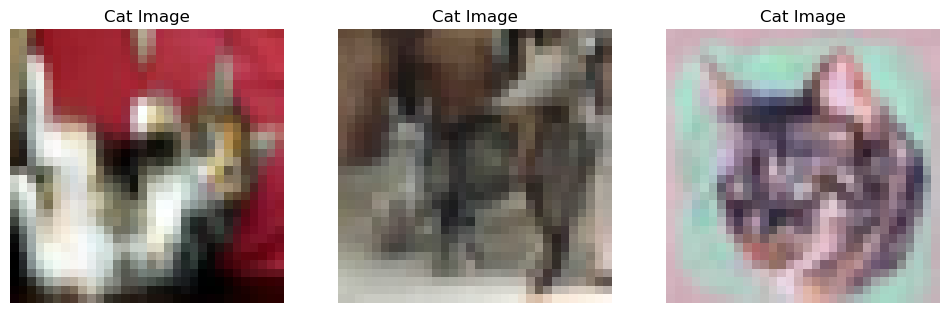

In [31]:
import matplotlib.pyplot as plt
import torchvision

# DataLoader에서 임의로 3장 선택하여 시각화
images, labels = next(iter(dataloader))
selected_images = images[:3]  # 첫 3장의 이미지 선택

# 이미지를 다시 [0, 1] 범위로 변환 (정규화 해제)
selected_images = (selected_images * 0.5) + 0.5

# 이미지 출력
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):
    img = torchvision.transforms.ToPILImage()(selected_images[i])
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title("Cat Image")
plt.show()

In [ ]:
# 생성기 모델 정의
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
             # (입력크기, 채널크기, 커널크기, stride, padding)
             # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            # (256,8,8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            # (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            # (3, 32, 32)
            nn.Tanh()
        )
    
    def forward(self, input):
        return self.main(input)

In [ ]:
# 판별기 모델 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False), 
            # (128, 16, 16)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            # (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            # (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            #  (1, 1, 1)
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [ ]:
# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델 초기화
nz = 100  # 노이즈 벡터의 차원

criterion = nn.BCELoss()

netG = Generator(nz).to(device)
netD = Discriminator().to(device)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

# 학습 루프
num_epochs = 50
real_label = 1.0
fake_label = 0.0


# 학습 루프의 수정된 부분
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # 판별기 학습: 실제 데이터
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0) # batch 크기
        labels = torch.full((b_size,), real_label, dtype=torch.float, device=device) # 참값 덩어리들, real 데이터의 참값은 1
        
        output = netD(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        # 판별기 학습: 생성된 데이터
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(fake_label)
        
        output = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        optimizerD.step()

        # 생성기 학습
        netG.zero_grad()
        labels.fill_(real_label)
        output = netD(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

        # 진행 상황 출력
        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(dataloader)}] '
                  f'Loss_D: {lossD_real.item() + lossD_fake.item():.4f} Loss_G: {lossG.item():.4f}')

print("학습 완료!")

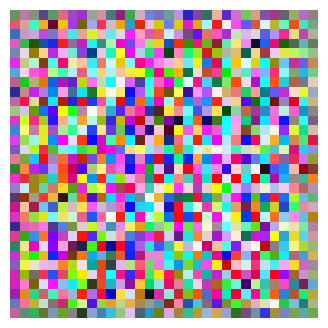

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Generator를 학습된 상태로 둔다고 가정
# netG는 학습이 완료된 Generator 모델입니다.

# Generator에 입력할 노이즈 벡터 생성
nz = 100  # 노이즈 벡터의 차원
num_samples = 1  # 생성할 이미지 수
noise = torch.randn(num_samples, nz, 1, 1, device=device)

# Generator를 통해 가짜 이미지 생성
with torch.no_grad():  # Gradient 계산 비활성화 (생성 시 필요 없음)
    fake_images = netG(noise).detach().cpu()

# 생성된 이미지 시각화
plt.figure(figsize=(4, 4))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(fake_images, padding=2, normalize=True), (1, 2, 0)))
plt.show()
